## Import Packages

In [1]:
import gc
import math
import numpy as np
import pandas as pd
import numba as nb
from sklearn.datasets import load_digits

from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

import scipy as sp

import skcuda
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
import skcuda.linalg as culinalg
from pycuda.compiler import SourceModule
from pycuda.autoinit import context
import pycuda.driver as drv
pycuda.autoinit.device
culinalg.init()

import matplotlib.pyplot as plt
%matplotlib inline

import sys
import os
import itertools
import time

C:\Users\willf\Anaconda3\lib\site-packages\skcuda\cublas.py:273: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


## Load Data

In [2]:
X_train = pd.read_csv('https://web.stanford.edu/~hastie/ElemStatLearn/datasets/vowel.train', sep=',', header=0)
X_test = pd.read_csv('https://web.stanford.edu/~hastie/ElemStatLearn/datasets/vowel.test', sep=',', header=0)

y_train = np.float32(X_train.iloc[:,1]) - 1
y_test = np.float32(X_test.iloc[:,1]) - 1
X_train = np.float32(X_train.drop(X_train.columns[1], axis=1).as_matrix())
X_test = np.float32(X_test.drop(X_test.columns[1], axis=1).as_matrix())

# Scale data according to the training data
scaler_all = preprocessing.StandardScaler()
scaler_all.fit(X_train)
X_train = scaler_all.transform(X_train)
X_test = scaler_all.transform(X_test)

## Declare Functions

In [3]:
# Input: np.ndarray, x
# Output: l2-norm of x
# Note: This seems to be marginally faster than np.linalg.norm...
def fasterNorm(x):
    return np.sqrt(x.dot(x))

# Input:
# - beta: model coefficients, np.ndarray of dimension (d,)
# - lambduh: l2-regularization parameter, float
# - y_y_hat: Element-wise product of y & y_hat (i.e., X.dot(beta)), np.ndarray of dimension (n,)
# Output: Huberized squared hinge loss objective
def obj(beta, lambduh, y_y_hat):
    loss = np.mean(svmObjCondition(y_y_hat, 0.5))
    return loss + lambduh * fasterNorm(beta)**2

# Input:
# - x: alias for y_y_hat, i.e., element-wise product of y & y_hat (i.e., X.dot(beta)), np.ndarray of dimension (n,)
# - h: threshold value for Huberized squared hinge loss objective, float
# Output: Element-wise conditional component of Huberized squared hinge loss objective, np.ndarray of dimension (n,)
# Note: Uses numba.vectorize to quickly apply conditions to x
@nb.vectorize([nb.float64(nb.float64, nb.float64)])
def svmObjCondition(x, h = 0.5):
    if 1 - x < -h:
        return 0
    if 1 - x > h:
        return 1 - x
    
    return (1 - x + h)**2 / (4 * h)

# Input:
# - x: alias for y_y_hat, i.e., element-wise product of y & y_hat (i.e., X.dot(beta)), np.ndarray of dimension (n,)
# - h: threshold value for Huberized squared hinge loss objective, float
# Output: Element-wise conditional partial component of gradient of Huberized squared hinge loss objective, np.ndarray of dimension (n,)
# Note: Uses numba.vectorize to quickly apply conditions to x
@nb.vectorize([nb.float64(nb.float64, nb.float64)])
def svmGradCondition(x, h = 0.5):
    if 1 - x < -h:
        return 0
    if 1 - x > h:
        return 1
    
    return (1 - x + h) / (2 * h)

# These are custom PyCUDA kernels in C
# These do the same purpose as svmGradCondition & svmObjCondition, but applied to pycuda.GPUArray objects
modObj = SourceModule(
"""
/*
* svmObjCondition_GPU is a GPU kernel that applies the element-wise conditional loss function 
* from the Huberized squared hinge loss.
*
* See obj_GPU for details.
*
* Input: a, pycuda.gpuarray.GPUArray (n,1) array
* Return: None (void)
* Action: the pycuda.gpuarray.GPUArray (n,1) array, dest, is updated according to loss function
*
*/
__global__ void svmObjCondition_GPU(float *a, float *dest)
{
    const int i = threadIdx.x;
    if(1 - a[i] < -0.5){
        dest[i] = 0;
    } else if(1 - a[i] > 0.5){
        dest[i] = 1 - a[i];
    } else {
        dest[i] = (1 - a[i] + 0.5) * (1 - a[i] + 0.5) / 2;
    }
}

/*
* svmGradCondition_GPU is a GPU kernel that applies the element-wise (partial) gradient
* of the conditional loss function from the Huberized squared hinge loss. The full gradient
* is computed downstream by performing a particular GPU matrix product. 
*
* See computegrad_GPU for details.
*
* Input: a, pycuda.gpuarray.GPUArray (n,1) array
* Return: None (void)
* Action: the pycuda.gpuarray.GPUArray (n,1) array, dest, is updated according to partiail gradient
*/
__global__ void svmGradCondition_GPU(float *a, float *dest)
{
    const int i = threadIdx.x;
    if(1 - a[i] < -0.5){
        dest[i] = 0;
    } else if(1 - a[i] > 0.5){
        dest[i] = 1;
    } else {
        dest[i] = (1 - a[i] + 0.5);
    }
}
"""
)

# These are prepared call function calls in PyCUDA.
# By preparing the function call earlier & declaring expected data types of "P" (i.e., GPUArrays),
# the functions run much faster.
svmObjCondition_GPU = modObj.get_function("svmObjCondition_GPU")
svmGradCondition_GPU = modObj.get_function("svmGradCondition_GPU")
svmObjCondition_GPU.prepare("PP")
svmGradCondition_GPU.prepare("PP")

# Input:
# - shape: integer tuple representing desired shape of GPUArray
# - ary1D: np.ndarray of dimension (n,) containing data to be stored in the GPUArray Data_GPU
# - stream: PyCUDA stream for asynchronous data transfer between host and device
# Output:
# - Data_aligned: memory aligned array of dimension (n,1) containing data from ary1D
# - Data_GPU_da: PyCUDA.DeviceAllocation object denoting where data is stored on the GPU
# - Data_pin: pinned memory array of dimension (n,1) linked to Data_aligned
# - Data_GPU: pycuda.GPUArray object generated by Data_GPU_da and Data_pin
# Assume: shape = (n, 1) for some n, to facilitate GPU matrix multiplication requiring such dimensions
def pinArrayToGPU(shape, ary1D, stream):
    # Align memory
    Data_aligned = drv.aligned_empty(shape = shape, dtype = np.float32)
    
    # Load data
    Data_aligned[:,0] = ary1D
    
    # Allocate GPU memory
    Data_GPU_da = drv.mem_alloc(Data_aligned.nbytes)
    
    # Pin memory
    Data_pin = drv.register_host_memory(Data_aligned)
    
    # Send to GPU
    drv.memcpy_htod_async(Data_GPU_da, Data_pin, stream)
    
    # Create GPUArray object
    Data_GPU = gpuarray.GPUArray(shape = shape, dtype = np.float32, gpudata = Data_GPU_da)
    
    # Wait for kernel to complete before returning to CPU
    drv.Context.synchronize()
    
    return Data_aligned, Data_GPU_da, Data_pin, Data_GPU

# Input:
# - shape: integer tuple representing desired shape of GPUArray
# - ary2D: np.ndarray of dimension (n,d) containing data to be stored in the GPUArray Data_GPU
# - stream: PyCUDA stream for asynchronous data transfer between host and device
# Output:
# - Data_aligned: memory aligned array of dimension (n,d) containing data from ary1D
# - Data_GPU_da: PyCUDA.DeviceAllocation object denoting where data is stored on the GPU
# - Data_pin: pinned memory array of dimension (n,d) linked to Data_aligned
# - Data_GPU: pycuda.GPUArray object generated by Data_GPU_da and Data_pin
def pinMatrixToGPU(shape, ary2D, stream):
    # Align memory
    Data_aligned = drv.aligned_empty(shape = shape, dtype = np.float32)
    
    # Load data
    Data_aligned[:,:] = ary2D
    
    # Allocate GPU memory
    Data_GPU_da = drv.mem_alloc(Data_aligned.nbytes)
    
    # Pin memory
    Data_pin = drv.register_host_memory(Data_aligned)
    
    # Send to GPU
    drv.memcpy_htod_async(Data_GPU_da, Data_pin, stream)
    
    # Create GPUArray object
    Data_GPU = gpuarray.GPUArray(shape = shape, dtype = np.float32, gpudata = Data_GPU_da)
    
    # Wait for kernel to complete before returning to CPU
    drv.Context.synchronize()
    
    return Data_aligned, Data_GPU_da, Data_pin, Data_GPU

# Input:
# - shape: integer tuple representing desired shape of GPUArray
# - Data_aligned: memory aligned array of dimension (n,d) containing data from ary1D
# - Data_GPU_da: PyCUDA.DeviceAllocation object denoting where data is stored on the GPU
# - Data_pin: pinned memory array of dimension (n,d) linked to Data_aligned
# - ary1D_new: np.ndarray of dimension (n,) containing new data to be stored in the GPUArray Data_GPU
# - stream: PyCUDA stream for asynchronous data transfer between host and device
# Output:
# - Data_GPU: pycuda.GPUArray object generated by Data_GPU_da and Data_pin
def updateGPUArray(shape, Data_aligned, Data_GPU_da, Data_pin, ary1D_new, stream):
    # Change aligned variable
    Data_aligned[:,0] = ary1D_new

    # Update the GPU device allocation
    drv.memcpy_htod_async(Data_GPU_da, Data_pin, stream)

    # Build new GPU object
    Data_GPU = gpuarray.GPUArray(shape = shape, dtype = np.float32, gpudata = Data_GPU_da)
    
    # Wait for kernel to complete before returning to CPU
    drv.Context.synchronize()
    
    return Data_GPU

# Input:
# - X_GPU: pycuda.GPUArray object representing design matrix X
# - beta_GPU: pycuda.GPUArray object representing coefficient array beta
# - y_hat_GPU: pycuda.GPUArray object to store GPU-equivalent output of X.dot(beta)
# - y_hat_GPU_da: PyCUDA.DeviceAllocation object denoting where data is stored on the GPU for y_hat_GPU
# - y_hat_pin: pinned memory array of dimension (n,1) associated with y_hat_GPU
# - stream: PyCUDA stream for asynchronous data transfer between host and device
# Output:
# Void, but y_hat_GPU contains the GPU-equivalent output of X.dot(beta)
def compute_y_hat_GPU(X_GPU, beta_GPU, y_hat_GPU_da, y_hat_pin, y_hat_GPU, stream):
    # Use scikit-cuda package to perform matrix-vector multiplication on GPU
    # Store result in y_hat_GPU
    culinalg.dot(X_GPU, beta_GPU, out = y_hat_GPU)
    
    # Update the host pinned memory object
    drv.memcpy_dtoh_async(y_hat_pin, y_hat_GPU_da, stream)
    
    # Wait for kernel to complete before returning to CPU
    drv.Context.synchronize()
    
# Purpose: Compute objective
# Input:
# - beta: model coefficients, np.ndarray of dimension (d,)
# - lambduh: l2-regularization parameter, float
# - y_y_hat_GPU: pycuda.GPUArray object storing GPU-equivalent output of np.multiply(y, y_hat)
# - y_y_hat_mod_GPU: dummy pycuda.GPUArray object to store output from svmObjCondition_GPU
# - block: tuple of dimension 3 containing block lengths
# - grid: tuple of dimension 2 containing grid lengths
# - y_y_hat_mod_pin: pinned memory associated with y_y_hat_mod_GPU
# - y_y_hat_mod_GPU_da: device allocation objection associated with y_y_hat_mod_GPU
# - stream: PyCUDA stream for asynchronous data transfer between host and device
# Output: scalar representing Huberized squared hinge loss objective
def obj_GPU(beta, lambduh, y_y_hat_GPU, y_y_hat_mod_GPU, block, grid, y_y_hat_mod_pin, y_y_hat_mod_GPU_da, stream):

    # Apply conditional loss function of SVM to the product of y & y_hat, using a GPU kernel.
    # To improve performance, assume svmObjCondition_GPU has been prepared within pyCUDA, 
    # and so a prepared_call is performed.
    svmObjCondition_GPU.prepared_call(grid, block, y_y_hat_GPU.gpudata, y_y_hat_mod_GPU.gpudata)
    
    # Peform fast copy of data from GPU to CPU for the output from svmObjCondition_GPU
    drv.memcpy_dtoh_async(y_y_hat_mod_pin, y_y_hat_mod_GPU_da, stream)
    
    # Wait for kernel to complete before returning to CPU
    drv.Context.synchronize()

    # Return mean loss with l2-regularization component
    return np.mean(y_y_hat_mod_pin) + lambduh * np.dot(beta, beta)

# Purpose: Compute gradient of objective
# Input:
# - beta: model coefficients, np.ndarray of dimension (d,)
# - lambduh: l2-regularization parameter, float
# - n: number of observations in y_y_hat_GPU
# - y_y_hat_GPU: pycuda.GPUArray object storing GPU-equivalent output of np.multiply(y, y_hat)
# - y_y_hat_mod_GPU: dummy pycuda.GPUArray object to store output from svmGradCondition_GPU
# - minusX_row_yT_GPU: pycuda.GPUArray representing -(X * y[:,None]).T
# - block: tuple of dimension 3 containing block lengths
# - grid: tuple of dimension 2 containing grid lengths
# - grad_loss_GPU: pycuda.GPUArray object to store GPU-equivalent output of -(X * y[:,None]).T.dot(y_y_hat_mod)
# - grad_loss_GPU_da: PyCUDA.DeviceAllocation object denoting where data is stored on the GPU for grad_loss_GPU
# - grad_loss_pin: pinned memory array of dimension (d,1) associated with grad_loss_GPU
# - stream: PyCUDA stream for asynchronous data transfer between host and device
# Output: np.ndarray(size = d) representing gradient of objective given inputs
def computegrad_GPU(beta, lambduh, n, y_y_hat_GPU, y_y_hat_mod_GPU, minusX_row_yT_GPU, block, grid, grad_loss_pin, grad_loss_GPU_da, grad_loss_GPU, stream):
    
    # Apply (partial) gradient of conditional loss function to the product of y & y_hat, using a GPU kernel.
    # To improve performance, assume svmGradCondition_GPU has been prepared within pyCUDA, 
    # and so a prepared_call is performed.
    svmGradCondition_GPU.prepared_call(grid, block, y_y_hat_GPU.gpudata, y_y_hat_mod_GPU.gpudata)
    
    # Compute product -(X * y[:,None]).T.dot(y_y_hat_mod) with GPU objects
    culinalg.dot(minusX_row_yT_GPU, y_y_hat_mod_GPU, out = grad_loss_GPU)
    
    # Peform fast copy of data from GPU to CPU for the output from svmGradCondition_GPU
    drv.memcpy_dtoh_async(grad_loss_pin, grad_loss_GPU_da, stream)
    
    # Wait for kernel to complete before returning to CPU
    drv.Context.synchronize()
    
    return grad_loss_pin/n + 2 * lambduh * beta

# Input:
# - x: beta coefficient
# - grad_x: gradient of x
# - y_y_hat: array equal to np.multiply(y, y_hat), where y_hat = X.dot(beta)
# - y_y_hat_grad: array equal to np.multiply(y, y_hat_grad), where y_hat_grad = X.dot(gradient(beta))
# - lambduh: l2-regularization parameter, float
# - n: deprecated parameter, ignore
# - objCurrent: current objective value
# - alpha: backtracking parameter used to check condition
# - gamma: backtracking parameter used to shrink x as needed
# - max_iter: maximum backtracking iterations
# Output:
def backtracking_GPU(x, grad_x, y_y_hat, y_y_hat_grad, lambduh, n, objCurrent, t = 1, alpha = 0.5, gamma = 0.8, max_iter = 100):
    norm_factor = alpha * np.dot(grad_x, grad_x)
    found_t = False
    i = 0
    while (found_t is False and i < max_iter):
        beta_test = x - t * grad_x
        y_y_hat_test = y_y_hat - t * y_y_hat_grad
        if obj(beta = beta_test, lambduh = lambduh, y_y_hat = y_y_hat_test) < objCurrent - t * norm_factor:
            found_t = True
        elif i == max_iter - 1:
            raise('Maximum number of iterations of backtracking reached')
        else:
            t *= gamma
            i += 1
    return t

# Fast gradient descent algorithm with Huberized squared hinge loss objective
# Input:
# - beta_init: initial model coefficients, np.ndarray of dimension (d,)
# - theta_init: initial model coefficients, np.ndarray of dimension (d,)
# - lambduh: l2-regularization parameter, float
# - eta_init: initial step size for fast gradient descent algorithm, float
# - X: design matrix as np.ndarray with dimension (n,d)
# - y: response vector as np.ndarray with dimension (n,)
# - eps: Convergence tolerance for norm of gradient of beta
# - onlyFinalIteration: parameter designating whether data should only be stored from the first and last iterations
# Output: Dictionary containing,
# - beta: np.array containing saved beta coefficients from selected iterations
# - theta: np.array containing saved theta coefficients from selected iterations
# - norm grad beta: np.array containing saved l2-norm of gradient of beta coefficients from selected iterations
# - eta: np.array containing saved eta step-sizes from selected iterations
# - obj: np.array containing saved objective values from selected iterations
# - final iter: number of iterations required before convergence tolerance met
def mylinearsvm_GPU(beta_init, theta_init, lambduh, eta_init, X, y, eps = 0.001, onlyFinalIteration = 0):
    # Setup & initialization
    n, d = X.shape
    beta = np.copy(beta_init)
    theta = np.copy(theta_init)
    X_row_y = X * y[:, None]
    minusX_row_yT_GPU = gpuarray.to_gpu(np.ascontiguousarray(-X_row_y.T))
    y_hat_beta = np.empty_like(y)
    y_hat_theta = np.empty_like(y)
    
    # Define variables related to pyCUDA prepared_calls for custom kernels
    grid = (1, 1)
    block = (1024,1,1)
    stream = drv.Stream()
    
    # Create GPU-related objects
    X_aligned, X_GPU_da, X_pin, X_GPU = pinMatrixToGPU(shape = (n,d), ary2D = X, stream = stream)
    beta_aligned, beta_GPU_da, beta_pin, beta_GPU = pinArrayToGPU(shape = (d,1), ary1D = beta, stream = stream)
    theta_aligned, theta_GPU_da, theta_pin, theta_GPU = pinArrayToGPU(shape = (d,1), ary1D = theta, stream = stream)
    y_hat_beta_aligned, y_hat_beta_GPU_da, y_hat_beta_pin, y_hat_beta_GPU = pinArrayToGPU(shape = (n,1), ary1D = y_hat_beta, stream = stream)
    y_hat_theta_aligned, y_hat_theta_GPU_da, y_hat_theta_pin, y_hat_theta_GPU = pinArrayToGPU(shape = (n,1), ary1D = y_hat_theta, stream = stream)
    
    compute_y_hat_GPU(X_GPU = X_GPU, beta_GPU = beta_GPU, y_hat_GPU_da = y_hat_beta_GPU_da, y_hat_pin = y_hat_beta_pin, y_hat_GPU = y_hat_beta_GPU, stream = stream)
    compute_y_hat_GPU(X_GPU = X_GPU, beta_GPU = theta_GPU, y_hat_GPU_da = y_hat_theta_GPU_da, y_hat_pin = y_hat_theta_pin, y_hat_GPU = y_hat_theta_GPU, stream = stream)
    
    y_y_hat_beta = np.multiply(y, y_hat_beta_pin[:,0])
    y_y_hat_theta = np.multiply(y, y_hat_theta_pin[:,0])

    # Create more GPU-related objects
    y_y_hat_beta_aligned, y_y_hat_beta_GPU_da, y_y_hat_beta_pin, y_y_hat_beta_GPU = pinArrayToGPU(shape = (n,1), ary1D = y_y_hat_beta, stream = stream)
    y_y_hat_theta_aligned, y_y_hat_theta_GPU_da, y_y_hat_theta_pin, y_y_hat_theta_GPU = pinArrayToGPU(shape = (n,1), ary1D = y_y_hat_theta, stream = stream)    
    
    # Dummy variables for GPU calculations
    # These store and transfer intermediate calculations in order to use the fast copying between GPU <-> CPU for pinned memory
    y_y_hat_mod = np.empty_like(y)
    grad_loss = np.empty_like(beta)
    y_y_hat_mod_aligned, y_y_hat_mod_GPU_da, y_y_hat_mod_pin, y_y_hat_mod_GPU = pinArrayToGPU(shape = (n,1), ary1D = y_y_hat_mod, stream = stream)
    grad_loss_aligned, grad_loss_GPU_da, grad_loss_pin, grad_loss_GPU = pinArrayToGPU(shape = (d,1), ary1D = grad_loss, stream = stream)        
    
    # Initialize gradients for beta and theta
    grad_beta = computegrad_GPU(beta = beta_pin, lambduh = lambduh, n = n, y_y_hat_GPU = y_y_hat_beta_GPU, y_y_hat_mod_GPU = y_y_hat_mod_GPU, minusX_row_yT_GPU = minusX_row_yT_GPU, block = block, grid = grid, grad_loss_pin = grad_loss_pin, grad_loss_GPU_da = grad_loss_GPU_da, grad_loss_GPU = grad_loss_GPU, stream = stream)
    grad_theta = computegrad_GPU(beta = theta_pin, lambduh = lambduh, n = n, y_y_hat_GPU = y_y_hat_theta_GPU, y_y_hat_mod_GPU = y_y_hat_mod_GPU, minusX_row_yT_GPU = minusX_row_yT_GPU, block = block, grid = grid, grad_loss_pin = grad_loss_pin, grad_loss_GPU_da = grad_loss_GPU_da, grad_loss_GPU = grad_loss_GPU, stream = stream)
    
    # Initialize objective values for beta and theta
    # Note: leaving syntax for obj_GPU as an example
#     obj_current_beta = obj_GPU(beta = beta_pin[:,0], lambduh = lambduh, y_y_hat_GPU = y_y_hat_beta_GPU, y_y_hat_mod_GPU = y_y_hat_mod_GPU, block = block, grid = grid, y_y_hat_mod_pin = y_y_hat_mod_pin, y_y_hat_mod_GPU_da = y_y_hat_mod_GPU_da, stream = stream)
#     obj_current_theta = obj_GPU(beta = theta_pin[:,0], lambduh = lambduh, y_y_hat_GPU = y_y_hat_theta_GPU, y_y_hat_mod_GPU = y_y_hat_mod_GPU, block = block, grid = grid, y_y_hat_mod_pin = y_y_hat_mod_pin, y_y_hat_mod_GPU_da = y_y_hat_mod_GPU_da, stream = stream)
    obj_current_beta = obj(beta = beta_pin[:,0], lambduh = lambduh, y_y_hat = y_y_hat_beta)
    obj_current_theta = obj(beta = theta_pin[:,0], lambduh = lambduh, y_y_hat = y_y_hat_theta)

    # Create more GPU-related objects
    y_hat_grad_theta = np.empty_like(y)
    y_hat_grad_theta_aligned, y_hat_grad_theta_GPU_da, y_hat_grad_theta_pin, y_hat_grad_theta_GPU = pinArrayToGPU(shape = (n,1), ary1D = y_hat_grad_theta, stream = stream)
    grad_theta_aligned, grad_theta_GPU_da, grad_theta_pin, grad_theta_GPU = pinArrayToGPU(shape = (d,1), ary1D = grad_theta[:,0], stream = stream)    
    
    compute_y_hat_GPU(X_GPU = X_GPU, beta_GPU = grad_theta_GPU, y_hat_GPU_da = y_hat_grad_theta_GPU_da, y_hat_pin = y_hat_grad_theta_pin, y_hat_GPU = y_hat_grad_theta_GPU, stream = stream)
    y_y_hat_grad_theta = np.multiply(y, y_hat_grad_theta_pin[:,0])
    
    # Store values
    beta_vals = [np.copy(beta)]
    theta_vals = [np.copy(theta)]
    norm_grad_beta_vals = [np.copy(fasterNorm(grad_beta[:,0]))]
    obj_vals = [np.copy(obj_current_beta)]
    eta = np.copy(eta_init)
    eta_vals = [np.copy(eta)]
    iter = 0
    while fasterNorm(grad_beta[:,0]) > eps:
        eta = backtracking_GPU(x = theta_pin[:,0], grad_x = grad_theta_pin[:,0], y_y_hat = y_y_hat_theta_pin[:,0], y_y_hat_grad = y_y_hat_grad_theta, lambduh = lambduh, n = n, objCurrent = obj_current_theta, t = eta, alpha = 0.5, gamma = 0.8, max_iter = 200)
        beta_prior = np.copy(beta)
        beta = theta - eta * grad_theta[:,0]
        theta = beta + iter / (iter + 3) * (beta - beta_prior)
        
        # Update GPU beta & theta values
        beta_GPU = updateGPUArray(shape = (d,1), Data_aligned = beta_aligned, Data_GPU_da = beta_GPU_da, Data_pin = beta_pin, ary1D_new = np.float32(beta), stream = stream)
        theta_GPU = updateGPUArray(shape = (d,1), Data_aligned = theta_aligned, Data_GPU_da = theta_GPU_da, Data_pin = theta_pin, ary1D_new = np.float32(theta), stream = stream)
        
        # Compute current y_hat variables in GPU
        compute_y_hat_GPU(X_GPU = X_GPU, beta_GPU = beta_GPU, y_hat_GPU_da = y_hat_beta_GPU_da, y_hat_pin = y_hat_beta_pin, y_hat_GPU = y_hat_beta_GPU, stream = stream)
        compute_y_hat_GPU(X_GPU = X_GPU, beta_GPU = theta_GPU, y_hat_GPU_da = y_hat_theta_GPU_da, y_hat_pin = y_hat_theta_pin, y_hat_GPU = y_hat_theta_GPU, stream = stream)

        # Compute current products of y & y_hat in CPU
        y_y_hat_beta = np.multiply(y, y_hat_beta_pin[:,0])
        y_y_hat_theta = np.multiply(y, y_hat_theta_pin[:,0])
        
        # Update current products of y & y_hat in GPU
        y_y_hat_beta_GPU = updateGPUArray(shape = (n,1), Data_aligned = y_y_hat_beta_aligned, Data_GPU_da = y_y_hat_beta_GPU_da, Data_pin = y_y_hat_beta_pin, ary1D_new = np.float32(y_y_hat_beta), stream = stream)
        y_y_hat_theta_GPU = updateGPUArray(shape = (n,1), Data_aligned = y_y_hat_theta_aligned, Data_GPU_da = y_y_hat_theta_GPU_da, Data_pin = y_y_hat_theta_pin, ary1D_new = np.float32(y_y_hat_theta), stream = stream)

        # Compute current objective values
#         obj_current_beta = obj_GPU(beta = beta_pin[:,0], lambduh = lambduh, y_y_hat_GPU = y_y_hat_beta_GPU, y_y_hat_mod_GPU = y_y_hat_mod_GPU, block = block, grid = grid, y_y_hat_mod_pin = y_y_hat_mod_pin, y_y_hat_mod_GPU_da = y_y_hat_mod_GPU_da, stream = stream)
#         obj_current_theta = obj_GPU(beta = theta_pin[:,0], lambduh = lambduh, y_y_hat_GPU = y_y_hat_theta_GPU, y_y_hat_mod_GPU = y_y_hat_mod_GPU, block = block, grid = grid, y_y_hat_mod_pin = y_y_hat_mod_pin, y_y_hat_mod_GPU_da = y_y_hat_mod_GPU_da, stream = stream)
        obj_current_beta = obj(beta = beta_pin[:,0], lambduh = lambduh, y_y_hat = y_y_hat_beta)
        obj_current_theta = obj(beta = theta_pin[:,0], lambduh = lambduh, y_y_hat = y_y_hat_theta)
        
        # Compute current gradients in GPU
        grad_beta = computegrad_GPU(beta = beta_pin, lambduh = lambduh, n = n, y_y_hat_GPU = y_y_hat_beta_GPU, y_y_hat_mod_GPU = y_y_hat_mod_GPU, minusX_row_yT_GPU = minusX_row_yT_GPU, block = block, grid = grid, grad_loss_pin = grad_loss_pin, grad_loss_GPU_da = grad_loss_GPU_da, grad_loss_GPU = grad_loss_GPU, stream = stream)
        grad_theta = computegrad_GPU(beta = theta_pin, lambduh = lambduh, n = n, y_y_hat_GPU = y_y_hat_theta_GPU, y_y_hat_mod_GPU = y_y_hat_mod_GPU, minusX_row_yT_GPU = minusX_row_yT_GPU, block = block, grid = grid, grad_loss_pin = grad_loss_pin, grad_loss_GPU_da = grad_loss_GPU_da, grad_loss_GPU = grad_loss_GPU, stream = stream)
        
        # Update GPU grad_theta values
        grad_theta_GPU = updateGPUArray(shape = (d,1), Data_aligned = grad_theta_aligned, Data_GPU_da = grad_theta_GPU_da, Data_pin = grad_theta_pin, ary1D_new = np.float32(grad_theta[:,0]), stream = stream)
        
        # Compute current y_hat_grad_theta values
        compute_y_hat_GPU(X_GPU = X_GPU, beta_GPU = grad_theta_GPU, y_hat_GPU_da = y_hat_grad_theta_GPU_da, y_hat_pin = y_hat_grad_theta_pin, y_hat_GPU = y_hat_grad_theta_GPU, stream = stream)
        
        # Compute current products of y & y_hat in CPU
        y_y_hat_grad_theta = np.multiply(y, y_hat_grad_theta_pin[:,0])
        
        iter += 1
        # Store values according to onlyFinalIteration
        if onlyFinalIteration == 0:
            beta_vals.append(np.copy(beta))
            theta_vals.append(np.copy(theta))
            norm_grad_beta_vals.append(np.copy(fasterNorm(grad_beta[:,0])))
            eta_vals.append(np.copy(eta))
            obj_vals.append(np.copy(obj_current_beta))
    
    # Store values according to onlyFinalIteration
    if onlyFinalIteration == 1:
        beta_vals.append(np.copy(beta))
        theta_vals.append(np.copy(theta))
        norm_grad_beta_vals.append(np.copy(fasterNorm(grad_beta[:,0])))
        eta_vals.append(np.copy(eta))
        obj_vals.append(np.copy(obj_current_beta))
    
    # Manually release device allocation memory
    # Note: only added to troubleshoot excessive memory...doesn't seem to work....
    X_GPU_da.free()
    beta_GPU_da.free()
    theta_GPU_da.free()
    y_hat_beta_GPU_da.free()
    y_hat_theta_GPU_da.free()
    y_y_hat_beta_GPU_da.free()
    y_y_hat_theta_GPU_da.free()
    grad_loss_GPU_da.free()
    y_y_hat_mod_GPU_da.free()
    grad_theta_GPU_da.free()
    y_hat_grad_theta_GPU_da.free()
    
    # Manually release pinned memory
    # Note: only added to troubleshoot excessive memory...doesn't seem to work....
    X_pin.base.unregister()
    beta_pin.base.unregister()
    theta_pin.base.unregister()
    y_hat_beta_pin.base.unregister()
    y_hat_theta_pin.base.unregister()
    y_y_hat_beta_pin.base.unregister()
    y_y_hat_theta_pin.base.unregister()
    grad_loss_pin.base.unregister()
    y_y_hat_mod_pin.base.unregister()
    grad_theta_pin.base.unregister()
    y_hat_grad_theta_pin.base.unregister()        
    
    # Delete GPU-related objects
    del minusX_row_yT_GPU,X_GPU,beta_GPU,theta_GPU,y_hat_beta_GPU,y_hat_theta_GPU,y_y_hat_beta_GPU,y_y_hat_theta_GPU,grad_loss_GPU,y_y_hat_mod_GPU,grad_theta_GPU,y_hat_grad_theta_GPU
    del X_pin,beta_pin,theta_pin,y_hat_beta_pin,y_hat_theta_pin,y_y_hat_beta_pin,y_y_hat_theta_pin,grad_loss_pin,y_y_hat_mod_pin,grad_theta_pin,y_hat_grad_theta_pin
    del X_aligned,beta_aligned,theta_aligned,y_hat_beta_aligned,y_hat_theta_aligned,y_y_hat_beta_aligned,y_y_hat_theta_aligned,grad_loss_aligned,y_y_hat_mod_aligned,grad_theta_aligned,y_hat_grad_theta_aligned
    
    # Run garbage collection
    gc.collect()
        
    return {"beta": np.array(beta_vals), "theta": np.array(theta_vals), "norm grad beta": np.array(norm_grad_beta_vals), "eta": np.array(eta_vals), "obj": np.array(obj_vals), "final iter": iter}

# Input:
# - lambduh_list: list of l2-regularization parameters to sequentially apply to the label-pair one-vs-one models set by label_combos below, floats
# - X: design matrix as np.ndarray with dimension (n,d)
# - y: response vector as np.ndarray with dimension (n,)
# - k_folds: number of cross-validation folds to perform, integer
# - eps: Convergence tolerance for norm of gradient of beta
# - eta_init_constant: optional initial step-size eta to be applied to all cross-validation runs.
#   If eta_init_constant = None, the initial step-size is inferred via 1 / (max eigenvalue / n + lambduh)
# Output: Dictionary containing,
# - misclassify means: np.ndarray of dimension (len(lambduh_list), k_folds)
# - lambda: copy of input lambduh_list
def mylinearsvm_CV_GPU(lambduh_list, X, y, k_folds, eps = 0.001, eta_init_constant = None):
    misclassify_vals = []
    timing = []
    num_labels = len(np.unique(y))
    label_combos = list(itertools.combinations(range(num_labels), 2))
    num_label_combos = len(label_combos)
    
    for pairIter in range(num_label_combos):
        if pairIter == 0:
            avg_run_time = 0
            sd_run_time = 0
        else:
            avg_run_time = np.mean(timing)
            sd_run_time = np.std(timing)
        print('Working on pair ' + str(pairIter + 1) + ' of ' + str(num_label_combos) + ', Average completion time per CV = ' + str(np.floor(avg_run_time * 100)/100) + ' +/- ' + str(np.floor(sd_run_time*10)/10) + ' s' + ', Expected time until completion = ' + str(np.floor((num_label_combos - pairIter - 1) * avg_run_time)) + ' s', flush = True, end = '\r')
        minLabel = label_combos[pairIter][0]
        maxLabel = label_combos[pairIter][1]
        X_pair, y_pair = construct_OvO_data(label_pair = [minLabel,maxLabel], X = X, y = y)
        
        start_time = time.time()
        output_CV = mylinearsvm_CV_GPU_backend(lambduh_list = lambduh_list, X = X_pair, y = y_pair, k_folds = k_folds, eps = eps, eta_init = eta_init_constant)
        end_time = time.time()
        timing.append(end_time - start_time)
        
        misclassify_vals.append(list(output_CV["misclassify means"]))
        del X_pair, y_pair, output_CV
        
        # Run garbage collection
        gc.collect()
        
    return {"misclassify means": misclassify_vals, "lambda": np.array(lambduh_list)}

# Input:
# - lambduh_list: list of l2-regularization parameters to sequentially apply to the label-pair one-vs-one models set by label_combos below, floats
# - X: design matrix as np.ndarray with dimension (n,d)
# - y: response vector as np.ndarray with dimension (n,)
# - k_folds: number of cross-validation folds to perform, integer
# - eps: Convergence tolerance for norm of gradient of beta
# - eta_init: initial step-size value, eta
# Output: Dictionary containing,
# - misclassify means: np.ndarray containing means of misclassifications from cross-validation
# - lambda: copy of input lambduh_list
# Assumes: lambduh_list is ordered from smallest to largest
def mylinearsvm_CV_GPU_backend(lambduh_list, X, y, k_folds, eps = 0.001, eta_init = None):
    n, d = X.shape
    indices_CV = getIndicesCV(n, k_folds)
    misclassify_vals = np.empty([len(lambduh_list), k_folds])
    
    # Do an initial run to get better initial beta guess for CV
    beta_init = np.float32(np.random.normal(size=d))
    if eta_init is None:
        max_eigenvalue = sp.linalg.eigh(np.dot(X.T, X), eigvals_only=True, eigvals=(d-1, d-1))
        eta_init = np.float64(1 / (max_eigenvalue / n + lambduh_list[0]))
    output_init = mylinearsvm_GPU(beta_init = beta_init, theta_init = np.copy(beta_init), lambduh = np.float32(lambduh_list[0]), eta_init = np.float32(eta_init), X = np.float32(X), y = np.float32(y), eps = eps, onlyFinalIteration = 1)
    beta_init = np.float32(np.copy(output_init['beta'][-1]))
    theta_init = np.float32(np.copy(output_init['theta'][-1]))
    eta_init = np.float32(np.copy(output_init['eta'][-1]))
    del output_init
    for k in range(k_folds):
        X_train_lamb = X[indices_CV[k][1],:]
        X_test_lamb = X[indices_CV[k][0],:]
        y_train_lamb = y[indices_CV[k][1]]
        y_test_lamb = y[indices_CV[k][0]]
        n = X_train_lamb.shape[0]

        # Scaling
        scaler = preprocessing.StandardScaler()
        scaler.fit(X_train_lamb)
        X_train_lamb = scaler.transform(X_train_lamb)
        X_test_lamb = scaler.transform(X_test_lamb)
        del scaler
        
        for lamb in range(len(lambduh_list)):
            output = mylinearsvm_GPU(beta_init = beta_init, theta_init = theta_init, lambduh = lambduh_list[lamb], eta_init = eta_init, X = np.float32(X_train_lamb), y = np.float32(y_train_lamb), eps = eps, onlyFinalIteration = 1)
            beta_init = np.float32(np.copy(output['beta'][-1]))
            theta_init = np.float32(np.copy(output['theta'][-1]))
            eta_init = np.float32(np.copy(output['eta'][-1]))
            
            misclassify_vals[lamb, k] = calcMisclassification(output['beta'][-1], X_test_lamb, y_test_lamb)
            gc.collect()
        
        del X_train_lamb, X_test_lamb, y_train_lamb, y_test_lamb, output
        
        # Run garbage collection
        gc.collect()
    
    misclassify_vals = np.mean(misclassify_vals, axis = 1)
        
    return {"misclassify means": misclassify_vals, "lambda": np.array(lambduh_list)}

# Input:
# - label_pair: tuple of dimension 2 specifying which response categories should be used to construct the subsetted data
# Note: label_pair assumes the first element is the smallest, second is largest
# - X: design matrix as np.ndarray with dimension (n,d)
# - y: response vector as np.ndarray with dimension (n,)
# - scale: optional parameter specifying whether the subsetted design matrix X_pair should be scaled
# Output:
# - X_pair: subset of X associated with records of y matching elements of label_pair
# - y_pair: subset of y associated with records of y matching elements of label_pair, where min(label_pair) is mapped to -1 and +1 otherwise.
def construct_OvO_data(label_pair, X, y, scale = True):
    
    # Find relevant category indices with mask
    indexes_pair = np.where(np.logical_or(y == label_pair[0], y == label_pair[1]))
    y_pair = np.empty_like(y[indexes_pair])
    X_pair = X[indexes_pair]

    # Define y_pair as vector of -1 and +1 according to record location of label pair in y
    y_pair[y[indexes_pair] == label_pair[0]] = -1
    y_pair[y[indexes_pair] == label_pair[1]] = 1

    # Scale design matrix
    if scale:
        scaler = preprocessing.StandardScaler()
        scaler.fit(X_pair)
        X_pair = scaler.transform(X_pair)
        del scaler
    
    X_pair = np.float32(X_pair)
    y_pair = np.float32(y_pair)
        
    return X_pair, y_pair

# Input:
# - lambduh_list: list of l2-regularization parameters to sequentially apply to the label-pair one-vs-one models set by label_combos below, floats
# - label_combos: list of 2D tuples representing all possible one-vs-one models with the first element representing the smallest category of the model pair
# - beta_init_list: list of initial beta coefficients to use in one-vs-one fitting
# - X: design matrix as np.ndarray with dimension (n,d)
# - y: response vector as np.ndarray with dimension (n,)
# - eps: Convergence tolerance for norm of gradient of beta
# - verbose: optional parameter to print additional information about the fitting process for each label pair
# Output: Dictionary containing,
# - svm output: list of all output from mylinearsvm_GPU for each label pair
# - lambda: copy of input lambduh_list
# - label combos: copy of input label_combos
def mysvm_OvO_GPU(lambduh_list, label_combos, beta_init_list, X, y, eps = 0.0001, verbose = False):
#     For a response with 100 categories, label_combos could be:
#     label_combos = list(itertools.combinations(range(100), 2))
    svm_output_list = []
    
    for pairIter in range(len(label_combos)):
        if verbose:
            print('\nStarting pair ',pairIter,': ',label_combos[pairIter], flush=True)
        
        # Construct needed data pairs
        start_time = time.time()       
        minLabel = list(label_combos[pairIter])[0]
        maxLabel = list(label_combos[pairIter])[1]
        X_pair, y_pair = construct_OvO_data(label_pair = [minLabel,maxLabel], X = X, y = y)
        
        # Setup initial values
        n, d = X_pair.shape
        beta_init = np.float32(beta_init_list[pairIter])
        max_eigen = sp.linalg.eigh(np.dot(X_pair.T, X_pair), eigvals_only=True, eigvals=(d-1, d-1))
        eta_init = np.float64(1 / (max_eigen / n + lambduh_list[pairIter]))
        
        end_time = time.time()
        if verbose:
            print("Total prep time: {}".format(end_time - start_time), flush=True)
        
        # Fit model
        start_time = time.time()
        output = mylinearsvm_GPU(beta_init = beta_init, theta_init = np.copy(beta_init), lambduh = lambduh_list[pairIter], eta_init = np.float32(eta_init), X = X_pair, y = y_pair, eps = eps, onlyFinalIteration = 1)
        svm_output_list.append(output)
        end_time = time.time()
        if verbose:
            print("Total fit time: {}".format(end_time - start_time), flush=True)
            
    return {"svm output": svm_output_list, "lambda": np.array(lambduh_list), "label combos": np.array(label_combos)}

# Input:
# - beta: model coefficients, np.ndarray of dimension (d,)
# - X: design matrix as np.ndarray with dimension (n,d)
# - y: response vector as np.ndarray with dimension (n,)
# Output: mean misclassification error between y and y_hat (after mapping positive y_hat values to +1, else -1)
def calcMisclassification(beta, X, y):    
    y_pred = X.dot(beta) > 0
    y_pred = np.int32(2 * y_pred - 1)
    return np.mean(y_pred != y)

# Input:
# - y: response vector as np.ndarray with dimension (n,)
# - y_hat: predicted categories as np.ndarray with dimension (n,)
# Output: mean misclassification error between y and y_hat
def calcMisclassification_allPairs(y, y_hat):
    return np.mean(y != y_hat)

# Get indices to build cross-validation data subsets
# Input:
# - n: number of observations in X and y
# - k_folds: number of folds to use in cross-validation
# Output: list containing training and testing indices for k-folds
# E.g., X[indices_CV[i][1],:] represents the training subset of the ith fold
# E.g., X[indices_CV[i][0],:] represents the testing subset of the ith fold
def getIndicesCV(n, k_folds):
    random_index_order = np.random.permutation(range(n))
    CV_index_dict = dict(enumerate(np.array_split(random_index_order, k_folds)))
    
    indices_CV = []
    for fold in range(k_folds):
        indices_fold = list(range(k_folds))
        del indices_fold[fold]
        indices_fold_test = CV_index_dict.get(fold)
        indices_fold_train = [CV_index_dict.get(key) for key in indices_fold]
        indices_fold_train = np.concatenate(indices_fold_train).ravel()
        indices_fold = [indices_fold_test, indices_fold_train]
        indices_CV.append(list(indices_fold))
    return indices_CV

# Find mode in vector. If there are multiple modes, randomly choose 1 to return.
# Input:
# - x: np.ndarray
# Output: index with largest argument, if one argmax. otherwise, randomly select indices in {argmax}
def modeRandomChoice(x):
    labelCounts = np.bincount(x)
    modeIndices = np.where(labelCounts == labelCounts.max())
    return np.random.choice(np.arange(np.max(x)+1)[modeIndices], 1)

# Input:
# - X_train: design matrix X used to train models associated with beta_list, np.ndarray of dimension (n,d)
# - y_train: response vector y used to train models associated with beta_list, np.ndarray of dimension (n,)
# - X_test: new design matrix X to use in scoring, np.ndarray of dimension (n,d)
# - beta_list: list of beta coefficients to use in scoring a dataset
# - OneVsOneLabelMatrix: np.ndarray representing all possible label pairs, i.e., same as label_combos above
# Output: predicted categories from one-vs-one fitting, consistent with beta_list
def scoreSVM_OvO(X_train, y_train, X_test, beta_list, OneVsOneLabelMatrix):
    n_pairs = OneVsOneLabelMatrix.shape[0]
    n = X_test.shape[0]
    y_hat_cols = []
    
    for pairIter in range(n_pairs):        
        # Construct needed data pairs   
        minLabel = OneVsOneLabelMatrix[pairIter,0]
        maxLabel = OneVsOneLabelMatrix[pairIter,1]
        X_train_pair, y_train_pair = construct_OvO_data(label_pair = [minLabel,maxLabel], X = X_train, y = y_train, scale = False)
        
        # Center data-to-score consistent with training data
        scaler = preprocessing.StandardScaler()
        scaler.fit(X_train_pair)
        X_train_pair = scaler.transform(X_train_pair)
        X_test_pair = scaler.transform(X_test)
        
        # Score test data
        beta_pair = beta_list[pairIter]
        y_hat_cols.append(np.int32(X_test_pair.dot(beta_pair) > 0))
        
    # Restate y_hat_cols as a n x n_pairs array
    y_hat_cols = np.vstack(y_hat_cols).T
    
    # This is an n x n_pairs array
    y_hat_rows = np.asarray([range(n_pairs) for i in range(n)])
    
    # Extract categorical labels
    y_hat = OneVsOneLabelMatrix[y_hat_rows, y_hat_cols]
    
    return np.apply_along_axis(modeRandomChoice, axis = 1, arr = y_hat)[:,0]

## Run Cross-Validation

In [4]:
lambduh_list = np.float32([2**k for k in np.linspace(-11,-8,20)])

start_time = time.time()
mysvm_CV = mylinearsvm_CV_GPU(lambduh_list = lambduh_list, X = np.float32(X_train), y = np.float32(y_train), k_folds = 3, eps = 0.001)
end_time = time.time()
print('\nCompletion time: ', end_time - start_time)

# np.save('mysvm_CV.npy',mysvm_CV)
# mysvm_CV = np.load('mysvm_CV.npy').item()

Working on pair 55 of 55, Average completion time per CV = 8.57 +/- 1.5 s, Expected time until completion = 0.0 sss
Completion time:  473.12928223609924


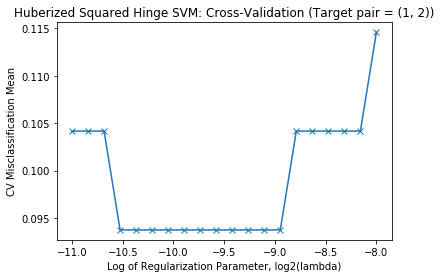

Optimal log2-lambda for pair (1, 2) = -9.651467


In [9]:
# These all look bad!
#### Manual inspection of all CV output
label_combos = list(itertools.combinations(range(11), 2))
misclassify_type = 'misclassify means'
cvPairIndex = 10
plt.plot(np.log2(mysvm_CV['lambda']), mysvm_CV[misclassify_type][cvPairIndex], marker="x")
plt.xlabel('Log of Regularization Parameter, log2(lambda)')
plt.ylabel('CV Misclassification Mean')
plt.title('Huberized Squared Hinge SVM: Cross-Validation (Target pair = ' + str(label_combos[cvPairIndex]) + ')')
plt.show()

# Find optimal lambda
minMisclassify_pair = np.min(mysvm_CV[misclassify_type][cvPairIndex])
minMisclassify_pair_index = np.where(mysvm_CV[misclassify_type][cvPairIndex] == minMisclassify_pair)
minMisclassify_pair_lambda = mysvm_CV['lambda'][minMisclassify_pair_index]
print('Optimal log2-lambda for pair ' + str(label_combos[cvPairIndex]) + ' = ' + str(np.log2(minMisclassify_pair_lambda.mean())))

## Fit Models with Optimal Lambdas

In [16]:
# Find optimal lambdas found through cross-validation

# Since this dataset seems to have poor features, i'm manually selecting a constant lambda value
optimal_lambdas = [np.float32(0.001) for i in range(len(label_combos))]

# for i in range(len(label_combos)):
#     minMisclassify_pair = np.min(mysvm_CV['misclassify means'][i])
#     minMisclassify_pair_index = np.where(mysvm_CV['misclassify means'][i] == minMisclassify_pair)
#     optimal_lambda_pair = np.float32(2**np.log2(mysvm_CV['lambda'][minMisclassify_pair_index]).mean())
#     optimal_lambdas.append(optimal_lambda_pair)
    
# np.save('optimal_lambdas.npy',optimal_lambdas)

In [17]:
# Fit one-vs-one models using optimal lambdas
d = X_train.shape[1]

beta_init = np.float32(np.random.normal(size=d))
beta_init_list = [beta_init] * len(label_combos)

mysvm_optimal_lambdas = mysvm_OvO_GPU(lambduh_list = optimal_lambdas, label_combos = label_combos, beta_init_list = beta_init_list, X = np.float32(X_train), y = np.float32(y_train), eps = 0.001, verbose = True)

# np.save('mysvm_optimal_lambdas.npy',mysvm_optimal_lambdas)


Starting pair  0 :  (0, 1)
Total prep time: 0.0020058155059814453
Total fit time: 0.359515905380249

Starting pair  1 :  (0, 2)
Total prep time: 0.0
Total fit time: 0.2852022647857666

Starting pair  2 :  (0, 3)
Total prep time: 0.0010037422180175781
Total fit time: 0.17947602272033691

Starting pair  3 :  (0, 4)
Total prep time: 0.001001596450805664
Total fit time: 0.18950438499450684

Starting pair  4 :  (0, 5)
Total prep time: 0.0010025501251220703
Total fit time: 0.2566821575164795

Starting pair  5 :  (0, 6)
Total prep time: 0.0010030269622802734
Total fit time: 0.1975240707397461

Starting pair  6 :  (0, 7)
Total prep time: 0.0
Total fit time: 0.20855379104614258

Starting pair  7 :  (0, 8)
Total prep time: 0.0010044574737548828
Total fit time: 0.32654786109924316

Starting pair  8 :  (0, 9)
Total prep time: 0.002004861831665039
Total fit time: 0.3629577159881592

Starting pair  9 :  (0, 10)
Total prep time: 0.0010044574737548828
Total fit time: 0.4090867042541504

Starting pair

## Evaluate Performance

In [19]:
optimal_betas = []
for pairIndex in range(len(label_combos)):
    optimal_betas.append(mysvm_optimal_lambdas['svm output'][pairIndex]['beta'][-1])

y_hat_test_optimal = scoreSVM_OvO(X_train = X_train, y_train = y_train, X_test = X_test, beta_list = optimal_betas, OneVsOneLabelMatrix = np.array(label_combos))
y_hat_train_optimal = scoreSVM_OvO(X_train = X_train, y_train = y_train, X_test = X_train, beta_list = optimal_betas, OneVsOneLabelMatrix = np.array(label_combos))

print('Misclassification rate on training data (per-model lambda from CV): ', calcMisclassification_allPairs(y_train, y_hat_train_optimal)*100)
print('Misclassification rate on testing data (per-model lambda from CV): ', calcMisclassification_allPairs(y_test, y_hat_test_optimal)*100)

Misclassification rate on training data (per-model lambda from CV):  8.333333333333332
Misclassification rate on testing data (per-model lambda from CV):  54.32900432900433
